In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import autoaugment
from torch.utils.data import DataLoader, random_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps:0 device


In [3]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.1.2
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-14.2-arm64-arm-64bit


In [4]:
def get_mean_std(dataset):
    mean_rgb = [np.mean(image.numpy(), axis=(1, 2)) for image, _ in dataset]
    std_rgb = [np.std(image.numpy(), axis=(1, 2)) for image, _ in dataset]

    mean_r = np.mean([m[1] for m in mean_rgb])
    mean_g = np.mean([m[0] for m in mean_rgb])
    mean_b = np.mean([m[2] for m in mean_rgb])

    std_r = np.mean([s[1] for s in std_rgb])
    std_g = np.mean([s[0] for s in std_rgb])
    std_b = np.mean([s[2] for s in std_rgb])

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)


transform_resize = transforms.Compose(
    [transforms.Resize((256, 256)), transforms.ToTensor()]
)

root_dir = "/Users/eric/Documents/Research/CDAL/2023_Winter/summer2winter_yosemite"

resize_train = datasets.ImageFolder(
    root=os.path.join(root_dir, "train"), transform=transform_resize
)
resize_test = datasets.ImageFolder(
    root=os.path.join(root_dir, "test"), transform=transform_resize
)

In [5]:
resize_train_mean = get_mean_std(resize_train)[0]
resize_train_std = get_mean_std(resize_train)[1]

resize_test_mean = get_mean_std(resize_test)[0]
resize_test_std = get_mean_std(resize_test)[1]

print(get_mean_std(resize_train))
print(get_mean_std(resize_test))

((0.41567704, 0.392973, 0.42644823), (0.2261155, 0.23222448, 0.25842425))
((0.41126862, 0.3889217, 0.42376348), (0.22638863, 0.23134208, 0.259804))


In [6]:
# !pip install albumentations

In [7]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from PIL import Image
import os
import torchvision.transforms as transforms
import albumentations
import albumentations.pytorch


class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, label=0):
        self.img_dir = img_dir
        self.transform = transform
        self.label = label
        self.img_paths = [
            os.path.join(img_dir, img_file)
            for img_file in os.listdir(img_dir)
            if img_file.lower().endswith(("png", "jpg", "jpeg"))
        ]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        return image, self.label


# 이미지 경로
root_dir_train = (
    "/Users/eric/Documents/Research/CDAL/2023_Winter/summer2winter_yosemite/train"
)
root_dir_test = (
    "/Users/eric/Documents/Research/CDAL/2023_Winter/summer2winter_yosemite/test"
)

## 이미지 변환 설정
transform_train = albumentations.Compose(
    [
        albumentations.Resize(256, 256),
        albumentations.OneOf(
            [
                albumentations.HorizontalFlip(p=0.8),
                albumentations.RandomRotate90(p=0.8),
                albumentations.VerticalFlip(p=0.8),
            ],
            p=1,
        ),
        albumentations.OneOf(
            [
                albumentations.MotionBlur(p=0.75),
                albumentations.OpticalDistortion(p=0.75),
                albumentations.GaussNoise(p=0.75),
            ],
            p=1,
        ),
        albumentations.Normalize(resize_train_mean, resize_train_std),
        albumentations.pytorch.transforms.ToTensorV2(),
    ]
)

transform_test = albumentations.Compose(
    [
        albumentations.Resize(256, 256),
        albumentations.Normalize(resize_test_mean, resize_test_std),
        albumentations.pytorch.transforms.ToTensorV2(),
    ]
)

In [8]:
# 데이터셋 생성
train_dataset_summer = CustomImageDataset(
    os.path.join(root_dir_train, "train_summer"), transform=transform_train, label=0
)
train_dataset_winter = CustomImageDataset(
    os.path.join(root_dir_train, "train_winter"), transform=transform_train, label=1
)

test_dataset_summer = CustomImageDataset(
    os.path.join(root_dir_test, "test_summer"), transform=transform_test, label=0
)
test_dataset_winter = CustomImageDataset(
    os.path.join(root_dir_test, "test_winter"), transform=transform_test, label=1
)

# 데이터셋 합치기
train_dataset = ConcatDataset([train_dataset_summer, train_dataset_winter])
test_dataset = ConcatDataset([test_dataset_summer, test_dataset_winter])

# 검증 데이터셋 분할
val_split = 0.2
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset_split, val_dataset_split = random_split(
    train_dataset, [train_size, val_size]
)

# DataLoader 생성
train_loader = DataLoader(train_dataset_split, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_split, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# 클래스 가중치 계산
class_counts = [0, 0]  # 클래스 수에 따라 조정
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = [sum(class_counts) / c for c in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [10]:
# 사전 훈련된 ResNet 모델 사용
class ResNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetModel, self).__init__()
        # ResNet50 모델 로드
        self.resnet = models.resnet50(pretrained=True)
        # ResNet의 마지막 완전 연결 계층을 교체
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


# 모델을 디바이스로 이동
model = ResNetModel(num_classes=2).to(device)
# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


/Users/eric/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/eric/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# 훈련 및 검증 함수 정의
def train(model, train_loader, optimizer, criterion, alpha=1.0):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(images, labels)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss.backward()
        optimizer.step()
    train_loss /= total
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy


def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= total
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy


def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [12]:
# 손실 및 정확도 추적을 위한 리스트
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# 훈련 및 검증
epochs = 50
cnt = 0
for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(
        f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%"
    )

    cnt += 1

# 테스트 세트에서의 성능
test_accuracy = test(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

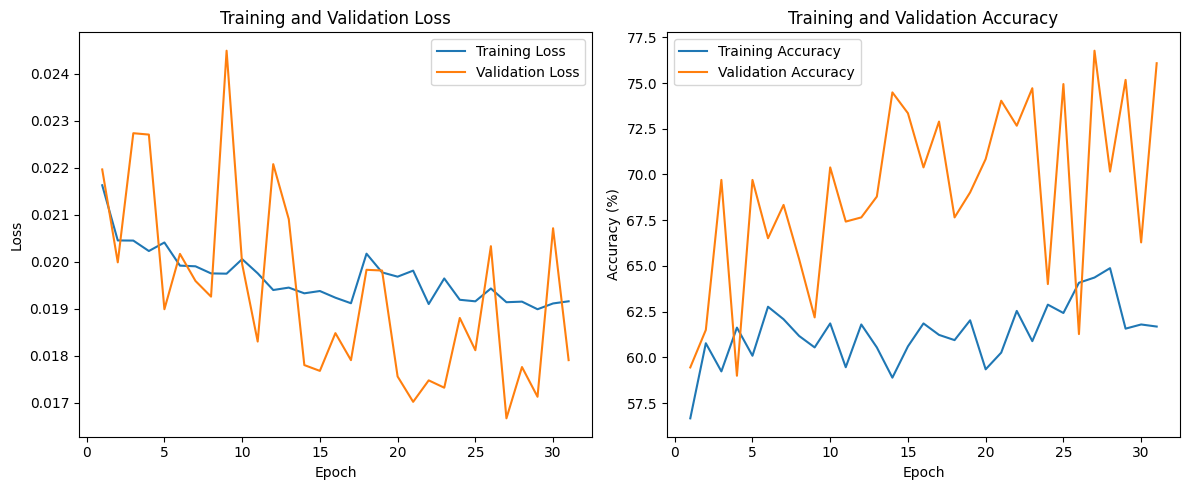

In [ ]:
# 손실 및 정확도 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, cnt + 1), train_losses, label="Training Loss")
plt.plot(range(1, cnt + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, cnt + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, cnt + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()